In [242]:
# Code for processing and plotting the pan angle, tilt angle, and distance sensor reading data sent by the Arduino
# J. Brettle

# import libraries
import serial
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize

---
## Receive and record data from Arduino:

In [243]:

# Note 1: This python script was designed to run with Python 3.
#
# Note 2: The script uses "pyserial" which must be installed.  If you have
#         previously installed the "serial" package, it must be uninstalled
#         first.
#
# Note 3: While this script is running you can not re-program the Arduino.
#         Before downloading a new Arduino sketch, you must exit this
#         script first.
arduinoComPort = "COM5"

# Set the baud rate
baudRate = 9600

# open the serial port
serialPort = serial.Serial(arduinoComPort, baudRate, timeout=1)

# set these values the same as in the Arduino script so that 
# the array doesn't have to be resized every time it's added to
panMin = 0
panMax = 50
panStep = 1
tiltMin = 0
tiltMax = 60
tiltStep = 1

# create a blank array for panPos, tiltPos, senseVal, and radius/distance to be stored in
numRows = int(((tiltMax-tiltMin)/tiltStep +1)*((panMax-panMin)/panStep +1))
ptsrData = [[0]*4] * numRows # using python array instead of numpy array because it's easier to print and look inside for debugging

# main loop to read data from the Arduino, then store it in ptsrData
i = 0
while i < numRows:
    # ask for a line of data from the serial port, the ".decode()" converts the
    # data from an "array of bytes", to a string
    lineOfData = serialPort.readline().decode()

    # check if data was received
    if len(lineOfData) > 0:

        # check if line is only one character long (3 with linebreaks)
        if len(lineOfData) == 3: # Arduino sent just a 1, scan is done
            print(ptsrData)
            i = numRows
        else: # continue with this scan
            # data was received, convert it into 4 integers
            panPos, tiltPos, senseVal = (int(x) for x in lineOfData.split(','))

            # print the results
            print([panPos, tiltPos, senseVal, 0.0])
            ptsrData[i] = [panPos, tiltPos, senseVal, 0.0]
            i = i+1

# convert to numpy array for easier usage
ptsrNP = np.array(ptsrData)

[0, 0, 596, 0.0]
[0, 1, 612, 0.0]
[0, 2, 632, 0.0]
[0, 3, 545, 0.0]
[0, 4, 444, 0.0]
[0, 5, 44, 0.0]
[0, 6, 49, 0.0]
[0, 7, 6, 0.0]
[0, 8, 106, 0.0]
[0, 9, 26, 0.0]
[0, 10, 159, 0.0]
[0, 11, 48, 0.0]
[0, 12, 62, 0.0]
[0, 13, 62, 0.0]
[0, 14, 57, 0.0]
[0, 15, 28, 0.0]
[0, 16, 0, 0.0]
[0, 17, 14, 0.0]
[0, 18, 5, 0.0]
[0, 19, 8, 0.0]
[0, 20, 35, 0.0]
[0, 21, 4, 0.0]
[0, 22, 5, 0.0]
[0, 23, 19, 0.0]
[0, 24, 142, 0.0]
[0, 25, 97, 0.0]
[0, 26, 73, 0.0]
[0, 27, 18, 0.0]
[0, 28, 43, 0.0]
[0, 29, 8, 0.0]
[0, 30, 39, 0.0]
[0, 31, 0, 0.0]
[0, 32, 4, 0.0]
[0, 33, 188, 0.0]
[0, 34, 53, 0.0]
[0, 35, 19, 0.0]
[0, 36, 5, 0.0]
[0, 37, 5, 0.0]
[0, 38, 6, 0.0]
[0, 39, 12, 0.0]
[0, 40, 23, 0.0]
[0, 41, 4, 0.0]
[0, 42, 5, 0.0]
[0, 43, 204, 0.0]
[0, 44, 243, 0.0]
[0, 45, 133, 0.0]
[0, 46, 5, 0.0]
[0, 47, 5, 0.0]
[0, 48, 6, 0.0]
[0, 49, 12, 0.0]
[0, 50, 4, 0.0]
[0, 51, 4, 0.0]
[0, 52, 144, 0.0]
[0, 53, 203, 0.0]
[0, 54, 225, 0.0]
[0, 55, 300, 0.0]
[0, 56, 300, 0.0]
[0, 57, 330, 0.0]
[0, 58, 350, 0.0]
[0, 59,



## Option to load and view saved data from `.npy` file:

In [418]:
# np.load("scan2.npy") # uncomment to load a saved scan

print("\n ptsrNP (panPos, tiltPos, senseVal, radius/distance (empty on a new scan)):")
print(ptsrNP)


 ptsrNP (panPos, tiltPos, senseVal, radius/distance (empty on a new scan)):
[[  0.           0.         596.          20.32      ]
 [  0.           1.         612.          20.32      ]
 [  0.           2.         632.          20.32      ]
 ...
 [ 50.          58.         387.          26.92682424]
 [ 50.          59.         400.          25.7984496 ]
 [ 50.          60.         411.          24.92150045]]


---
## Use calibration data obtained with `dist_sensor_calibrate.py` to create a calibration function `p` (and plot):


 dsNP (measured distance, senseVal) aka Calibration Data:
[[ 20.32 460.  ]
 [ 25.4  405.  ]
 [ 27.94 375.  ]
 [ 30.48 355.  ]
 [ 33.02 330.  ]
 [ 35.56 310.  ]
 [ 40.64 273.  ]
 [ 50.8  211.  ]
 [ 60.96 173.  ]
 [ 71.12 157.  ]
 [ 81.28 138.  ]
 [ 91.44 110.  ]
 [101.6  102.  ]
 [111.76  95.  ]
 [121.92  82.  ]
 [132.08  65.  ]
 [142.24  50.  ]
 [152.4   40.  ]]

 coefficients of best fit polynomial (calibration function), starting with highest powers:
[-3.65061637e-13  6.06411748e-10 -3.91519416e-07  1.20403803e-04
 -1.62491468e-02  1.60606055e-01  1.64109357e+02]


Text(0.5, 1.0, 'Calibration Data With 6th Degree Ployfit \n x = -3.651e-13y^6 + 6.064e-10y^5 - 3.915e-07y^4 + 1.204e-04y^3 - 1.624e-02y^2 + 1.606e-01y + 1.641e+02')

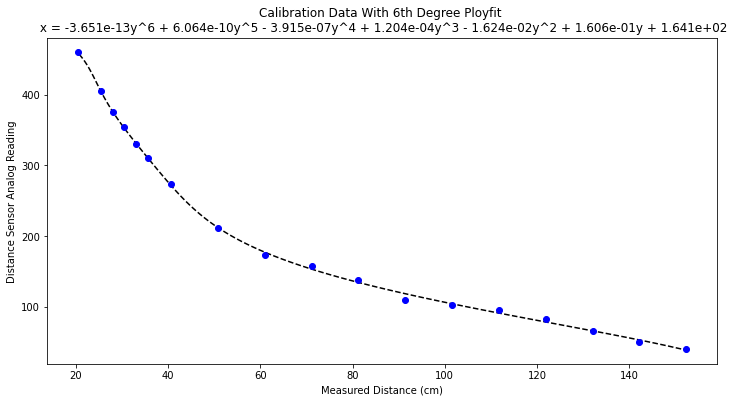

In [447]:
# load and print calibration data
dsNP = np.load("calibration_data_1.npy")
# dsNP = np.load("calibration_data.npy") # uncomment to use data just collected from dist_sensor_calibrate.py rather than saved data
print("\n dsNP (measured distance, senseVal) aka Calibration Data:")
print(dsNP)

# use numpy.polyfit to find best fit polynomial of degree 6
c = np.polyfit(dsNP[:,1],dsNP[:,0],6)
print("\n coefficients of best fit polynomial (calibration function), starting with highest powers:")
print(c)

p = np.poly1d(c) # use numpy.poly1d to convert coefficients to a function
xp = np.linspace(np.amin(dsNP[:,1]),np.amax(dsNP[:,1]), 100) # x values for plotting the calibration function p

fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
plt.plot(p(xp),xp, 'k--',dsNP[:,0],dsNP[:,1], 'bo')
ax.set_xlabel("Measured Distance (cm)")
ax.set_ylabel("Distance Sensor Analog Reading")
ax.set_title('Calibration Data With 6th Degree Ployfit \n x = -3.651e-13y^6 + 6.064e-10y^5 - 3.915e-07y^4 + 1.204e-04y^3 - 1.624e-02y^2 + 1.606e-01y + 1.641e+02')


## Test the above calibration function `p` with test distances, then calculate and plot error:


 dsTestNP (test distances, recorded sensor reading at that distance):
[[ 22.86 423.  ]
 [ 38.1  285.  ]
 [ 53.34 208.  ]
 [ 78.74 143.  ]]

 dsTestExpected (calibration function calculated distances for the sensor values in dsTest):
[24.00273474 38.83680402 51.71060338 76.30450968]

 errors (calibration function calculated distances minus measured distances):
[-1.14273474 -0.73680402  1.62939662  2.43549032]


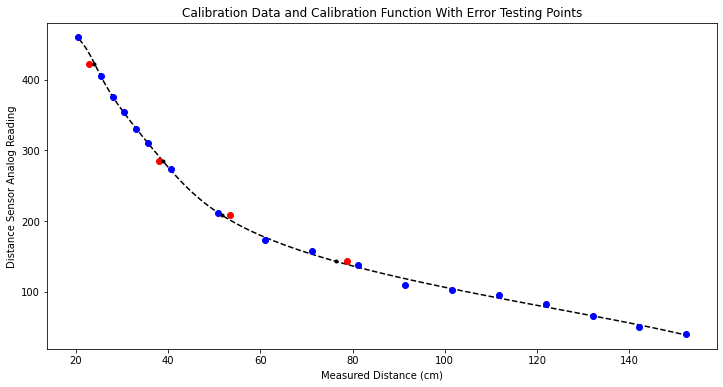

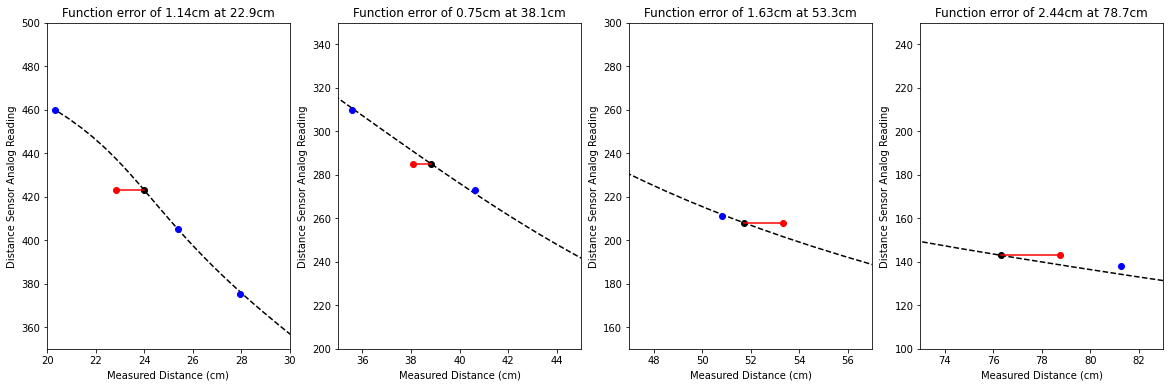

In [442]:
# load 4 test datapoints from previous successful run of dist_sensor_calibrate
dsTestNP = np.load("calibration_data_test_1.npy")
print("\n dsTestNP (test distances, recorded sensor reading at that distance):")
print(dsTestNP)

# calculate expected distances from the sensor values in dsTest
dsTestExpected = p(dsTestNP[:,1])
print("\n dsTestExpected (calibration function calculated distances for the sensor values in dsTest):")
print(dsTestExpected)
errors = dsTestNP[:,0]-dsTestExpected
print("\n errors (calibration function calculated distances minus measured distances):")
print(errors)

# plot test datapoints on top of original calibration plot
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
plt.plot(p(xp),xp, 'k--',dsNP[:,0],dsNP[:,1], 'bo', dsTestNP[:,0],dsTestNP[:,1], 'ro',dsTestExpected,dsTestNP[:,1], 'k.')
ax.set_xlabel("Measured Distance (cm)")
ax.set_ylabel("Distance Sensor Analog Reading")
ax.set_title('Calibration Data and Calibration Function With Error Testing Points')


# make subplots that are zoomed in on the 4 test datapoints

fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.set_title('Function error of 1.14cm at 22.9cm')
ax1.plot(p(xp),xp, 'k--', label='')
ax1.plot(dsNP[:,0],dsNP[:,1], 'bo', label='')
ax1.plot(dsTestNP[:,0],dsTestNP[:,1], 'ro', label='')
ax1.plot(dsTestExpected,dsTestNP[:,1], 'ko', label='')
ax1.plot([dsTestExpected[0],dsTestNP[0,0]],[dsTestNP[0,1],dsTestNP[0,1]], 'r-', label='')
ax1.set_xlim([20, 30])
ax1.set_ylim([350, 500])
ax1.set_xlabel("Measured Distance (cm)")
ax1.set_ylabel("Distance Sensor Analog Reading")

ax2.set_title('Function error of 0.75cm at 38.1cm')
ax2.plot(p(xp),xp, 'k--', label='')
ax2.plot(dsNP[:,0],dsNP[:,1], 'bo', label='')
ax2.plot(dsTestNP[:,0],dsTestNP[:,1], 'ro', label='')
ax2.plot(dsTestExpected,dsTestNP[:,1], 'ko', label='')
ax2.plot([dsTestExpected[1],dsTestNP[1,0]],[dsTestNP[1,1],dsTestNP[1,1]], 'r-', label='')
ax2.set_xlim([35, 45])
ax2.set_ylim([200, 350])
ax2.set_xlabel("Measured Distance (cm)")
ax2.set_ylabel("Distance Sensor Analog Reading")

ax3.set_title('Function error of 1.63cm at 53.3cm')
ax3.plot(p(xp),xp, 'k--', label='')
ax3.plot(dsNP[:,0],dsNP[:,1], 'bo', label='')
ax3.plot(dsTestNP[:,0],dsTestNP[:,1], 'ro', label='')
ax3.plot(dsTestExpected,dsTestNP[:,1], 'ko', label='')
ax3.plot([dsTestExpected[2],dsTestNP[2,0]],[dsTestNP[2,1],dsTestNP[2,1]], 'r-', label='')
ax3.set_xlim([47, 57])
ax3.set_ylim([150, 300])
ax3.set_xlabel("Measured Distance (cm)")
ax3.set_ylabel("Distance Sensor Analog Reading")

ax4.set_title('Function error of 2.44cm at 78.7cm')
ax4.plot(p(xp),xp, 'k--', label='')
ax4.plot(dsNP[:,0],dsNP[:,1], 'bo', label='')
ax4.plot(dsTestNP[:,0],dsTestNP[:,1], 'ro', label='')
ax4.plot(dsTestExpected,dsTestNP[:,1], 'ko', label='')
ax4.plot([dsTestExpected[3],dsTestNP[3,0]],[dsTestNP[3,1],dsTestNP[3,1]], 'r-', label='')
ax4.set_xlim([73, 83])
ax4.set_ylim([100, 250])
ax4.set_xlabel("Measured Distance (cm)")
ax4.set_ylabel("Distance Sensor Analog Reading")

plt.show()

---
## Use the calibration function on the scan data:


 ptsrNP (panPos, tiltPos, senseVal, radius/distance):
[[  0.           0.         596.          20.32      ]
 [  0.           1.         612.          20.32      ]
 [  0.           2.         632.          20.32      ]
 ...
 [ 50.          58.         387.          26.92682424]
 [ 50.          59.         400.          25.7984496 ]
 [ 50.          60.         411.          24.92150045]]


Text(0.5, 1.0, 'Calibration Data and Function with Mapped Scanned Distances')

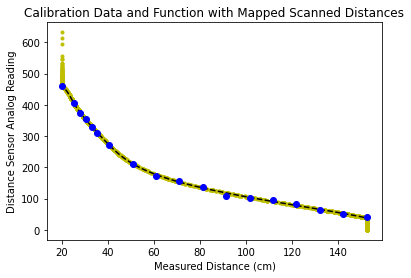

In [441]:
# For the senseVal column in the scan data (ptsrNP):
# If values are above or below the calibration points, make equal to the closest calibration points in dsNP
# because sensor and function are not reliable past those points.
# Otherwise, use the calibration function p to convert senseVal to a distance and put in last column of ptsrNP
i = 0
while i < numRows:
    if ptsrNP[i,2]>np.amax(dsNP[:,1]):
        ptsrNP[i,3] = np.amin(dsNP[:,0])
    elif ptsrNP[i,2]<np.amin(dsNP[:,1]):
        ptsrNP[i,3] = np.amax(dsNP[:,0])
    else:
        ptsrNP[i,3] = p(ptsrNP[i,2])
    i = i+1

print("\n ptsrNP (panPos, tiltPos, senseVal, radius/distance):")
print(ptsrNP)

# plot 3D scan's data with calibration data
fig = plt.figure()
ax = plt.axes()
plt.plot(ptsrNP[:,3],ptsrNP[:,2],'y.', p(xp),xp, 'k--',dsNP[:,0],dsNP[:,1], 'bo')
ax.set_xlabel("Measured Distance (cm)")
ax.set_ylabel("Distance Sensor Analog Reading")
ax.set_title('Calibration Data and Function with Mapped Scanned Distances')

## Option to save the scan data with distances determined by calibration function (4th column) in a `.npy` file:

In [ ]:
# np.save("scan4",ptsrNP) # uncomment to save the current scan

## Plot 3D scan data using a color-map to show depth:

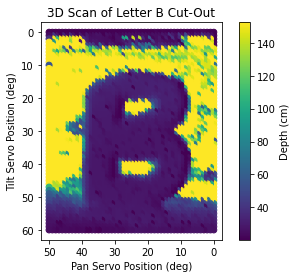

In [433]:
fig = plt.figure()
ax = plt.axes()
plt.scatter(ptsrNP[:,0],ptsrNP[:,1],s=None,c=ptsrNP[:,3])
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('equal', 'box')
ax.set_xlabel("Pan Servo Position (deg)")
ax.set_ylabel("Tilt Servo Position (deg)")
ax.set_title('3D Scan of Letter B Cut-Out')
plt.colorbar(label="Depth (cm)")


---
---
## Create plots for the data from the single-servo/pan-only exercise:

[[  0.          40.          23.         152.4       ]
 [  1.          40.           7.         152.4       ]
 [  2.          40.           0.         152.4       ]
 [  3.          40.           5.         152.4       ]
 [  4.          40.           5.         152.4       ]
 [  5.          40.           7.         152.4       ]
 [  6.          40.           5.         152.4       ]
 [  7.          40.          62.         135.06325235]
 [  8.          40.         390.          26.598136  ]
 [  9.          40.         476.          20.32      ]
 [ 10.          40.         396.          26.05826284]
 [ 11.          40.         368.          28.8057148 ]
 [ 12.          40.         382.          27.35958831]
 [ 13.          40.         368.          28.8057148 ]
 [ 14.          40.         370.          28.59069586]
 [ 15.          40.         368.          28.8057148 ]
 [ 16.          40.         350.          30.84800025]
 [ 17.          40.         323.          34.15217569]
 [ 18.    

Text(0.5, 1.0, 'Pan-Only Scan of Letter B Cut-out At 40 Degrees Tilt')

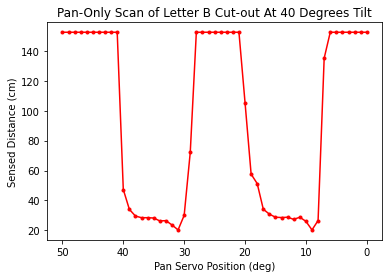

In [435]:
ptsr_pan = np.load("scan3_pan_only.npy")
print(ptsr_pan)

fig = plt.figure()
ax = plt.axes()
ax.invert_xaxis()
plt.plot(ptsr_pan[:,0],ptsr_pan[:,3], 'r.-')
ax.set_xlabel("Pan Servo Position (deg)")
ax.set_ylabel("Sensed Distance (cm)")
ax.set_title('Pan-Only Scan of Letter B Cut-out At 40 Degrees Tilt')


Text(0.5, 1.0, '3D Scan of Letter B Cut-Out With\nLine Indcating Pan-Only Scan Path')

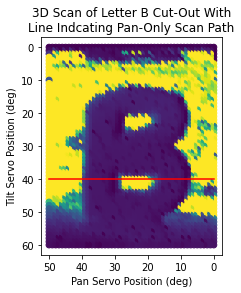

In [440]:
# draw a red line over the 3D scan data indicating where the pan-only data was taken
ptsrNP_loaded = np.load("scan2.npy")
fig = plt.figure()
ax = plt.axes()
ax.invert_xaxis()
ax.invert_yaxis()
plt.scatter(ptsrNP[:,0],ptsrNP[:,1],s=None,c=ptsrNP[:,3])
plt.plot([50,0],[40,40],'r-')
ax.set_aspect('equal', 'box')
ax.set_xlabel("Pan Servo Position (deg)")
ax.set_ylabel("Tilt Servo Position (deg)")
ax.set_title('3D Scan of Letter B Cut-Out With\nLine Indcating Pan-Only Scan Path')
